In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops
ops.reset_default_graph()

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('temp', one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting temp\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting temp\train-labels-idx1-ubyte.gz
Extracting temp\t10k-images-idx3-ubyte.gz
Extracting temp\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
train_set = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
test_set = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])
train_labels = mnist.train.labels
test_labels = mnist.test.labels

In [4]:
train_set[0].shape

(28, 28)

In [5]:
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = 28
image_height = 28
target_size = int(np.max(train_labels) + 1)
num_channels = 1 
generations = 1000
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2 
max_pool_size2 = 2 
fully_connected_size1 = 100

In [6]:
sess = tf.Session()

In [7]:
# calculate prediction accuracy 
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return 100. * num_correct/batch_predictions.shape[0]

## Model 1 fully_connect_1 -> fully_connect_2 -> predictions

In [8]:
def model_1_build(input_data, full1_weight, full1_bias, full2_weight, full2_bias):
    # Transform data to 1*N for fully connected NN
    input_data_shape = input_data.get_shape().as_list()
    modified_shape = input_data_shape[1] * input_data_shape[2] * input_data_shape[3]
    flat_data = tf.reshape(input_data, [input_data_shape[0], modified_shape])

    # Fully Connected Layer 1
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_data, full1_weight), full1_bias))

    # Fully Connected Layer 2
    model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    return model_output

In [9]:
def model_1(train_data, train_labels, test_data, test_labels, generations):
    # set up placeholders
    x_input_shape = (batch_size, image_width, image_height, num_channels)
    x_input = tf.placeholder(tf.float32, shape=x_input_shape)
    y_target = tf.placeholder(tf.int32, shape=(batch_size))
    
    eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
    eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
    eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))
    
    # set up variables
    resulting_width = image_width
    resulting_height = image_height
    full1_input_size = resulting_width * resulting_height
    full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
    full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))
    
    # outputs and loss
    model_output = model_1_build(x_input, full1_weight, full1_bias, full2_weight, full2_bias)
    test_model_output = model_1_build(eval_input, full1_weight, full1_bias, full2_weight, full2_bias)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
    
    my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_step = my_optimizer.minimize(loss)

    # Initialize Variables
    init = tf.global_variables_initializer()
    sess.run(init)
    
    print('model 1 (full_conn_1 -> full_connect_2 -> predictions)')
    
    prediction = tf.nn.softmax(model_output)
    test_prediction = tf.nn.softmax(test_model_output)
    
    train_loss = []
    train_acc = []
    test_acc = []
    for i in range(generations):
        rand_index = np.random.choice(len(train_data), size=batch_size)
        rand_x = train_data[rand_index]
        rand_x = np.expand_dims(rand_x, 3)
        rand_y = train_labels[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}
        sess.run(train_step, feed_dict=train_dict)
        
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

        if (i+1) % eval_every == 0:
            eval_index = np.random.choice(len(test_data), size=evaluation_size)
            eval_x = test_data[eval_index]
            eval_x = np.expand_dims(eval_x, 3)
            eval_y = test_labels[eval_index]
            test_dict = {eval_input: eval_x, eval_target: eval_y}
            test_preds = sess.run(test_prediction, feed_dict=test_dict)
            temp_test_acc = get_accuracy(test_preds, eval_y)

            # Record and print results
            train_loss.append(temp_train_loss)
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
            print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
    return train_loss, train_acc, test_acc


In [10]:
train_loss_1, train_acc_1, test_acc_1 = model_1(train_set, train_labels, test_set, test_labels, generations)

model 1 (full_conn_1 -> full_connect_2 -> predictions)
Generation # 5. Train Loss: 2.34. Train Acc (Test Acc): 11.00 (13.60)
Generation # 10. Train Loss: 2.19. Train Acc (Test Acc): 16.00 (18.40)
Generation # 15. Train Loss: 2.13. Train Acc (Test Acc): 24.00 (33.60)
Generation # 20. Train Loss: 1.97. Train Acc (Test Acc): 40.00 (43.20)
Generation # 25. Train Loss: 1.86. Train Acc (Test Acc): 47.00 (45.60)
Generation # 30. Train Loss: 1.80. Train Acc (Test Acc): 54.00 (57.20)
Generation # 35. Train Loss: 1.74. Train Acc (Test Acc): 58.00 (64.80)
Generation # 40. Train Loss: 1.66. Train Acc (Test Acc): 58.00 (64.60)
Generation # 45. Train Loss: 1.55. Train Acc (Test Acc): 54.00 (67.20)
Generation # 50. Train Loss: 1.42. Train Acc (Test Acc): 63.00 (70.60)
Generation # 55. Train Loss: 1.30. Train Acc (Test Acc): 78.00 (73.60)
Generation # 60. Train Loss: 1.28. Train Acc (Test Acc): 69.00 (73.20)
Generation # 65. Train Loss: 1.15. Train Acc (Test Acc): 73.00 (75.60)
Generation # 70. Train 

Generation # 635. Train Loss: 0.47. Train Acc (Test Acc): 84.00 (91.20)
Generation # 640. Train Loss: 0.36. Train Acc (Test Acc): 91.00 (89.00)
Generation # 645. Train Loss: 0.45. Train Acc (Test Acc): 87.00 (88.40)
Generation # 650. Train Loss: 0.23. Train Acc (Test Acc): 94.00 (90.80)
Generation # 655. Train Loss: 0.44. Train Acc (Test Acc): 86.00 (92.60)
Generation # 660. Train Loss: 0.33. Train Acc (Test Acc): 87.00 (89.40)
Generation # 665. Train Loss: 0.42. Train Acc (Test Acc): 90.00 (87.80)
Generation # 670. Train Loss: 0.29. Train Acc (Test Acc): 90.00 (93.40)
Generation # 675. Train Loss: 0.30. Train Acc (Test Acc): 91.00 (90.00)
Generation # 680. Train Loss: 0.24. Train Acc (Test Acc): 93.00 (91.40)
Generation # 685. Train Loss: 0.38. Train Acc (Test Acc): 89.00 (87.20)
Generation # 690. Train Loss: 0.22. Train Acc (Test Acc): 93.00 (89.60)
Generation # 695. Train Loss: 0.35. Train Acc (Test Acc): 91.00 (88.60)
Generation # 700. Train Loss: 0.31. Train Acc (Test Acc): 91.00 

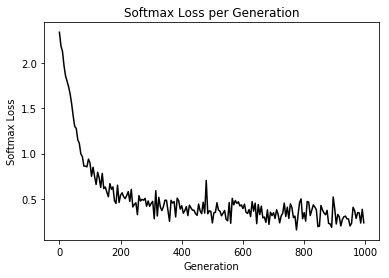

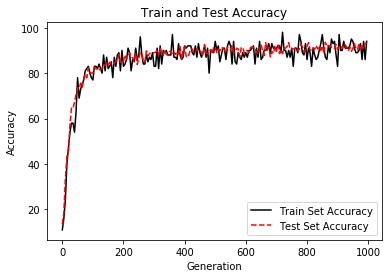

In [11]:
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
# Plot loss over time
plt.plot(eval_indices, train_loss_1, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot train and test accuracy
plt.plot(eval_indices, train_acc_1, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc_1, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Model 2 Convol - Maxpool - fully_connect_1 - fully_connect_2 -> predictions

In [12]:
def model_2_build(input_data, conv1_weight, conv1_bias, full1_weight, full1_bias, full2_weight, full2_bias):

    
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')

    final_conv_shape = max_pool1.get_shape().as_list()
    modified_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_data = tf.reshape(max_pool1, [final_conv_shape[0], modified_shape])
    
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_data, full1_weight), full1_bias))
    
    model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    return model_output

In [13]:
def model_2(train_data, train_labels, test_data, test_labels, generations):
    x_input_shape = (batch_size, image_width, image_height, num_channels)
    x_input = tf.placeholder(tf.float32, shape=x_input_shape)
    y_target = tf.placeholder(tf.int32, shape=(batch_size))
    
    eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
    eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
    eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))
    
    conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], stddev=0.1, dtype=tf.float32))
    conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

    resulting_width = image_width // max_pool_size1
    resulting_height = image_height // max_pool_size1 
    full1_input_size = resulting_width * resulting_height * conv1_features
    full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
    full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))
    
    model_output = model_2_build(x_input, conv1_weight, conv1_bias,full1_weight, full1_bias, full2_weight, full2_bias)
    test_model_output = model_2_build(eval_input, conv1_weight, conv1_bias, full1_weight, full1_bias, full2_weight, full2_bias)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
    
    my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_step = my_optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    sess.run(init)
    
    print('Model 2 (Convol -> Maxpool -> fully_connect_1 -> fully_connect_2 -> predictions')
    
    prediction = tf.nn.softmax(model_output)
    test_prediction = tf.nn.softmax(test_model_output)
    
    train_loss = []
    train_acc = []
    test_acc = []
    for i in range(generations):
        rand_index = np.random.choice(len(train_data), size=batch_size)
        rand_x = train_data[rand_index]
        rand_x = np.expand_dims(rand_x, 3)
        rand_y = train_labels[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}
        sess.run(train_step, feed_dict=train_dict)
        
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

        if (i+1) % eval_every == 0:
            eval_index = np.random.choice(len(test_data), size=evaluation_size)
            eval_x = test_data[eval_index]
            eval_x = np.expand_dims(eval_x, 3)
            eval_y = test_labels[eval_index]
            test_dict = {eval_input: eval_x, eval_target: eval_y}
            test_preds = sess.run(test_prediction, feed_dict=test_dict)
            temp_test_acc = get_accuracy(test_preds, eval_y)

            # Record and print results
            train_loss.append(temp_train_loss)
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
            print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
    return train_loss, train_acc, test_acc


In [14]:
train_loss_2, train_acc_2, test_acc_2 = model_2(train_set, train_labels, test_set, test_labels, generations)

Model 2 (Convol -> Maxpool -> fully_connect_1 -> fully_connect_2 -> predictions
Generation # 5. Train Loss: 2.34. Train Acc (Test Acc): 10.00 (12.20)
Generation # 10. Train Loss: 2.16. Train Acc (Test Acc): 23.00 (25.80)
Generation # 15. Train Loss: 2.07. Train Acc (Test Acc): 38.00 (36.80)
Generation # 20. Train Loss: 1.93. Train Acc (Test Acc): 53.00 (49.40)
Generation # 25. Train Loss: 1.84. Train Acc (Test Acc): 58.00 (58.60)
Generation # 30. Train Loss: 1.54. Train Acc (Test Acc): 66.00 (66.00)
Generation # 35. Train Loss: 1.34. Train Acc (Test Acc): 67.00 (68.00)
Generation # 40. Train Loss: 1.17. Train Acc (Test Acc): 70.00 (76.40)
Generation # 45. Train Loss: 0.97. Train Acc (Test Acc): 73.00 (78.60)
Generation # 50. Train Loss: 0.83. Train Acc (Test Acc): 80.00 (80.40)
Generation # 55. Train Loss: 0.75. Train Acc (Test Acc): 79.00 (82.20)
Generation # 60. Train Loss: 0.71. Train Acc (Test Acc): 79.00 (82.20)
Generation # 65. Train Loss: 0.51. Train Acc (Test Acc): 86.00 (85.40

Generation # 570. Train Loss: 0.11. Train Acc (Test Acc): 97.00 (93.80)
Generation # 575. Train Loss: 0.18. Train Acc (Test Acc): 95.00 (94.80)
Generation # 580. Train Loss: 0.32. Train Acc (Test Acc): 94.00 (93.60)
Generation # 585. Train Loss: 0.42. Train Acc (Test Acc): 91.00 (92.00)
Generation # 590. Train Loss: 0.15. Train Acc (Test Acc): 97.00 (92.80)
Generation # 595. Train Loss: 0.34. Train Acc (Test Acc): 92.00 (94.00)
Generation # 600. Train Loss: 0.19. Train Acc (Test Acc): 95.00 (95.60)
Generation # 605. Train Loss: 0.13. Train Acc (Test Acc): 97.00 (94.80)
Generation # 610. Train Loss: 0.31. Train Acc (Test Acc): 90.00 (94.60)
Generation # 615. Train Loss: 0.30. Train Acc (Test Acc): 91.00 (92.60)
Generation # 620. Train Loss: 0.17. Train Acc (Test Acc): 96.00 (92.60)
Generation # 625. Train Loss: 0.24. Train Acc (Test Acc): 92.00 (91.40)
Generation # 630. Train Loss: 0.31. Train Acc (Test Acc): 91.00 (93.40)
Generation # 635. Train Loss: 0.30. Train Acc (Test Acc): 90.00 

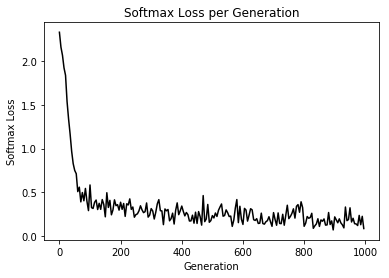

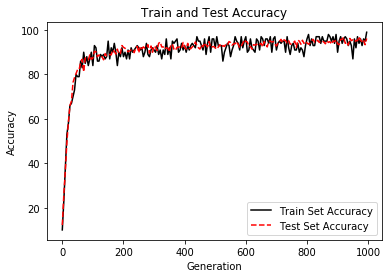

In [15]:
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
# Plot loss over time
plt.plot(eval_indices, train_loss_2, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot train and test accuracy
plt.plot(eval_indices, train_acc_2, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc_2, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Model 3 Convol_1 -> Maxpool_1 -> Convol_2 -> Maxpool_2 -> fully connect_1 -> fully connect_2 -> predictions

In [16]:
def model_3_build(input_data, conv1_weight, conv1_bias, conv2_weight, conv2_bias, full1_weight, full1_bias, full2_weight, full2_bias):

    
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')

    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1],
                               strides=[1, max_pool_size2, max_pool_size2, 1], padding='SAME')

    final_conv_shape = max_pool2.get_shape().as_list()
    modified_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], modified_shape])

    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))

    model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    return model_output

In [17]:
def model_3(train_data, train_labels, test_data, test_labels, generations):
    x_input_shape = (batch_size, image_width, image_height, num_channels)
    x_input = tf.placeholder(tf.float32, shape=x_input_shape)
    y_target = tf.placeholder(tf.int32, shape=(batch_size))
    
    eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
    eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
    eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))
    
    conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], stddev=0.1, dtype=tf.float32))
    conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))
    conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
    conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

    resulting_width = image_width // (max_pool_size1 * max_pool_size2)
    resulting_height = image_height // (max_pool_size1 * max_pool_size2)
    full1_input_size = resulting_width * resulting_height * conv2_features
    full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
    full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

    model_output = model_3_build(x_input, conv1_weight, conv1_bias, conv2_weight, conv2_bias, full1_weight, full1_bias, full2_weight, full2_bias)
    test_model_output = model_3_build(eval_input, conv1_weight, conv1_bias, conv2_weight, conv2_bias, full1_weight, full1_bias, full2_weight, full2_bias)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
    
    my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_step = my_optimizer.minimize(loss)

    # Initialize Variables
    init = tf.global_variables_initializer()
    sess.run(init)
    
    print('model 3 (Convol_1 -> Maxpool_1 -> Convol_2 -> Maxpool_2 -> fully connect_1 -> fully connect_2 -> predictions)')
    
    prediction = tf.nn.softmax(model_output)
    test_prediction = tf.nn.softmax(test_model_output)
    
    train_loss = []
    train_acc = []
    test_acc = []
    for i in range(generations):
        rand_index = np.random.choice(len(train_data), size=batch_size)
        rand_x = train_data[rand_index]
        rand_x = np.expand_dims(rand_x, 3)
        rand_y = train_labels[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}
        sess.run(train_step, feed_dict=train_dict)
        
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

        if (i+1) % eval_every == 0:
            eval_index = np.random.choice(len(test_data), size=evaluation_size)
            eval_x = test_data[eval_index]
            eval_x = np.expand_dims(eval_x, 3)
            eval_y = test_labels[eval_index]
            test_dict = {eval_input: eval_x, eval_target: eval_y}
            test_preds = sess.run(test_prediction, feed_dict=test_dict)
            temp_test_acc = get_accuracy(test_preds, eval_y)

            # Record and print results
            train_loss.append(temp_train_loss)
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
        if (i+1) % (eval_every * 10) == 0:
            print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
    return train_loss, train_acc, test_acc


In [18]:
train_loss_3, train_acc_3, test_acc_3 = model_3(train_set, train_labels, test_set, test_labels, generations)

model 3 (Convol_1 -> Maxpool_1 -> Convol_2 -> Maxpool_2 -> fully connect_1 -> fully connect_2 -> predictions)
Generation # 50. Train Loss: 0.57. Train Acc (Test Acc): 86.00 (80.40)
Generation # 100. Train Loss: 0.31. Train Acc (Test Acc): 90.00 (90.40)
Generation # 150. Train Loss: 0.23. Train Acc (Test Acc): 96.00 (91.40)
Generation # 200. Train Loss: 0.32. Train Acc (Test Acc): 90.00 (93.20)
Generation # 250. Train Loss: 0.26. Train Acc (Test Acc): 91.00 (92.00)
Generation # 300. Train Loss: 0.14. Train Acc (Test Acc): 94.00 (92.80)
Generation # 350. Train Loss: 0.13. Train Acc (Test Acc): 96.00 (95.00)
Generation # 400. Train Loss: 0.07. Train Acc (Test Acc): 98.00 (96.20)
Generation # 450. Train Loss: 0.11. Train Acc (Test Acc): 98.00 (95.20)
Generation # 500. Train Loss: 0.06. Train Acc (Test Acc): 98.00 (96.20)
Generation # 550. Train Loss: 0.05. Train Acc (Test Acc): 97.00 (97.80)
Generation # 600. Train Loss: 0.11. Train Acc (Test Acc): 97.00 (96.20)
Generation # 650. Train Los

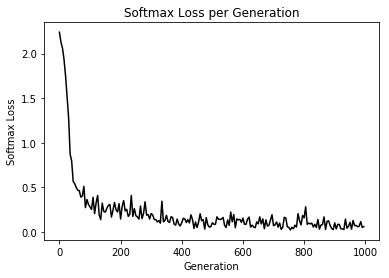

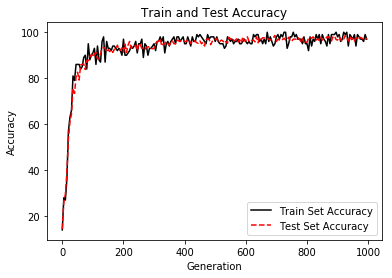

In [19]:
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
# Plot loss over time
plt.plot(eval_indices, train_loss_3, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot train and test accuracy
plt.plot(eval_indices, train_acc_3, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc_3, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Compare three models 

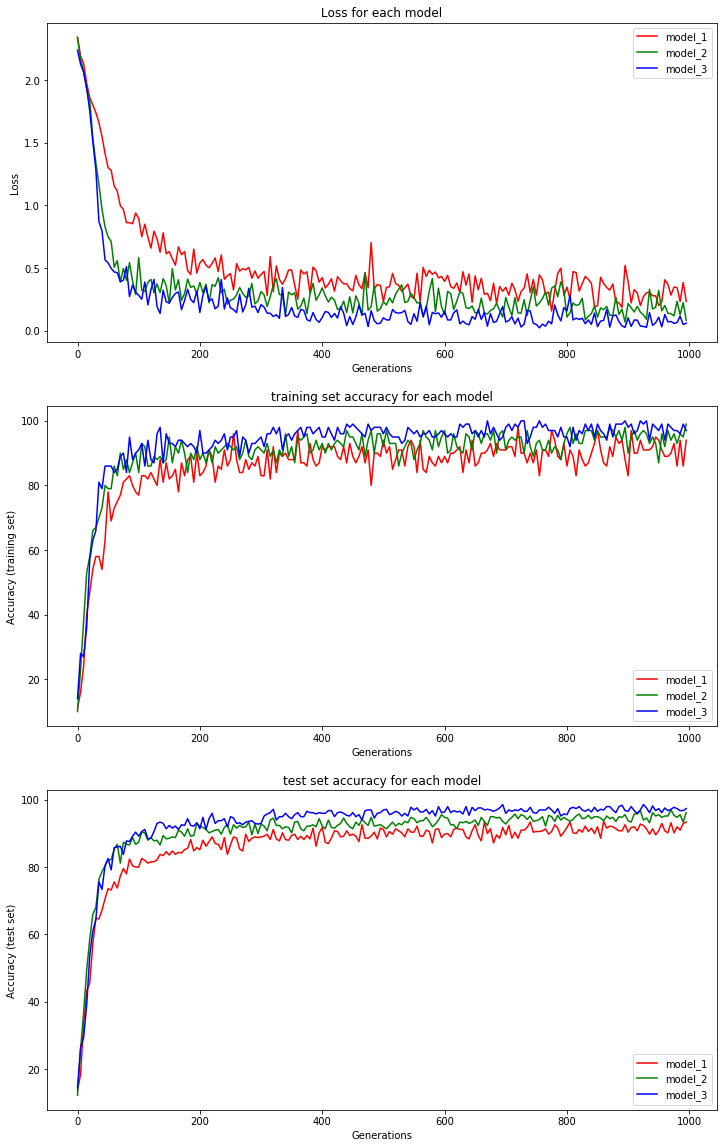

Test set accuracy (model 1): 93.4
Test set accuracy (model 2): 96.2
Test set accuracy (model 3): 97.4


In [20]:
plt.rcParams["figure.figsize"] = [12,20]

plt.subplot(311)
plt.plot(eval_indices, train_loss_1, 'r', label='model_1')
plt.plot(eval_indices, train_loss_2, 'g', label='model_2')
plt.plot(eval_indices, train_loss_3, 'b', label='model_3')
plt.title('Loss for each model')
plt.xlabel('Generations')
plt.legend(loc='upper right')
plt.ylabel('Loss')
#plt.ylim(0, 5)

plt.subplot(312)
plt.plot(eval_indices, train_acc_1, 'r', label='model_1')
plt.plot(eval_indices, train_acc_2, 'g', label='model_2')
plt.plot(eval_indices, train_acc_3, 'b', label='model_3')
plt.title('training set accuracy for each model')
plt.xlabel('Generations')
plt.legend(loc='lower right')
plt.ylabel('Accuracy (training set)')
#plt.ylim(0, 5)

plt.subplot(313)
plt.plot(eval_indices, test_acc_1, 'r', label='model_1')
plt.plot(eval_indices, test_acc_2, 'g', label='model_2')
plt.plot(eval_indices, test_acc_3, 'b', label='model_3')
plt.title('test set accuracy for each model')
plt.xlabel('Generations')
plt.legend(loc='lower right')
plt.ylabel('Accuracy (test set)')
#plt.ylim(0, 5)

plt.show()

print('Test set accuracy (model 1): {}'.format(test_acc_1[-1]))
print('Test set accuracy (model 2): {}'.format(test_acc_2[-1]))
print('Test set accuracy (model 3): {}'.format(test_acc_3[-1]))

## Visualize wronge predictions 

In [57]:
def get_wronge_predictions(train_data, train_labels, test_data, test_labels, generations):
    x_input_shape = (batch_size, image_width, image_height, num_channels)
    x_input = tf.placeholder(tf.float32, shape=x_input_shape)
    y_target = tf.placeholder(tf.int32, shape=(batch_size))
    
    eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
    eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
    eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))
    
    conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], stddev=0.1, dtype=tf.float32))
    conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))
    conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
    conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

    resulting_width = image_width // (max_pool_size1 * max_pool_size2)
    resulting_height = image_height // (max_pool_size1 * max_pool_size2)
    full1_input_size = resulting_width * resulting_height * conv2_features
    full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
    full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

    model_output = model_3_build(x_input, conv1_weight, conv1_bias, conv2_weight, conv2_bias, full1_weight, full1_bias, full2_weight, full2_bias)
    test_model_output = model_3_build(eval_input, conv1_weight, conv1_bias, conv2_weight, conv2_bias, full1_weight, full1_bias, full2_weight, full2_bias)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
    
    my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_step = my_optimizer.minimize(loss)

    # Initialize Variables
    init = tf.global_variables_initializer()
    sess.run(init)
    
    print('model 3 (Convol_1 -> Maxpool_1 -> Convol_2 -> Maxpool_2 -> fully connect_1 -> fully connect_2 -> predictions)')
    
    prediction = tf.nn.softmax(model_output)
    test_prediction = tf.nn.softmax(test_model_output)
    
    train_loss = []
    train_acc = []
    test_acc = []
    for i in range(generations):
        rand_index = np.random.choice(len(train_data), size=batch_size)
        rand_x = train_data[rand_index]
        rand_x = np.expand_dims(rand_x, 3)
        rand_y = train_labels[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}
        sess.run(train_step, feed_dict=train_dict)
        
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

       
    eval_index = np.random.choice(len(test_data), size=evaluation_size)
    eval_x = test_data[eval_index]
    eval_x = np.expand_dims(eval_x, 3)
    eval_y = test_labels[eval_index]
    test_dict = {eval_input: eval_x, eval_target: eval_y}
    test_preds = sess.run(test_prediction, feed_dict=test_dict)
    
    batch_predictions = np.argmax(test_preds, axis=1)
    not_match = ~np.equal(batch_predictions, eval_y)
    x = eval_x[not_match]
    true_y = eval_y[not_match]
    predict_y = batch_predictions[not_match]
    
    
    return x, true_y, predict_y


In [58]:
x_img, true_y, predict_y = get_wrong_predictions(train_set, train_labels, test_set, test_labels, generations)

model 3 (Convol_1 -> Maxpool_1 -> Convol_2 -> Maxpool_2 -> fully connect_1 -> fully connect_2 -> predictions)


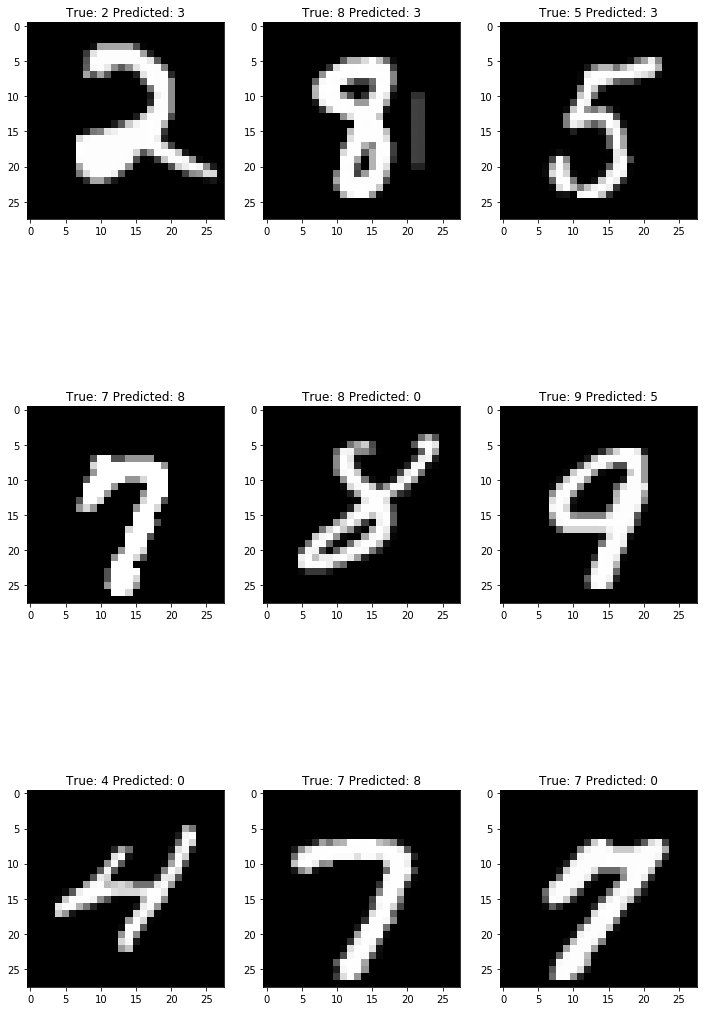

In [56]:
Nrows = 3
Ncols = 3
for i in range(9):
    plt.subplot(Nrows, Ncols, i+1)
    plt.imshow(np.reshape(x_img[i], [28,28]), cmap='Greys_r')
    plt.title('True: ' + str(true_y[i]) + ' Predicted: ' + str(predict_y[i]),fontsize=12)
plt.show()